In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import math

DATA_DIR = "../data/spectrogram_data/"

In [26]:
X_ls = []
y_ls = []
X0shape = 0
for x_file in sorted(os.listdir(DATA_DIR)):
    if "X" not in x_file:
        continue
    num_str = "".join([j for j in filter(str.isdigit, x_file)])
    X = np.load(DATA_DIR + x_file)
    X0shape += X.shape[0]
    Xrestshape = X.shape[1:]
    y = np.load(f"{DATA_DIR}/sub-{num_str}_y.npy")
    assert X.shape[0] == y.shape[0]
    #print(X.shape)
    # print(X.reshape(X.shape[0], -1).shape, y.shape)
    X_ls.append(X.reshape(X.shape[0], -1))
    y_ls.append(y)

# Set reference counts to 0 to try to reclaim space
X = np.concatenate(X_ls)
X_ls = None
y = np.concatenate(y_ls)
y_ls = None

X_mean = X.mean()
X_std = X.std()
X = (X - X_mean) / (X_std + 1e-8)
X_mean = None
X_std = None

In [27]:
X0shape

69705

In [28]:
Xrestshape

(19, 33, 7)

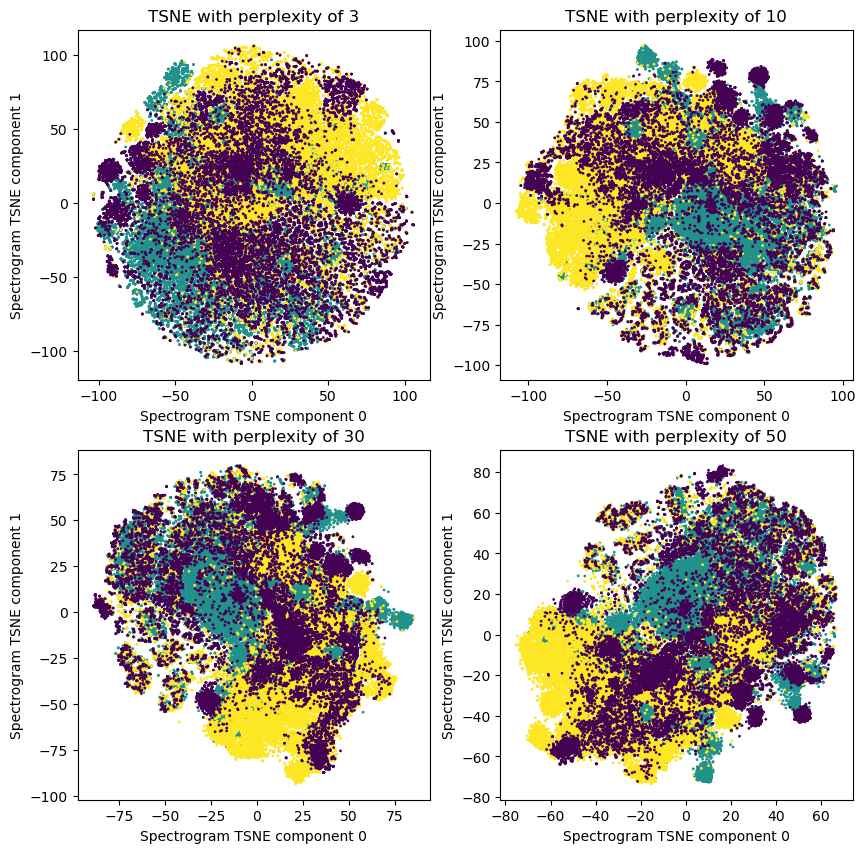

In [7]:
# Look at tsne visualizations on 
perplexities = [3, 10, 30, 50]
plen = len(perplexities)
sqrt = int(math.sqrt(plen))
fig, axes = plt.subplots(sqrt,sqrt, figsize=(10,10))
for i in range(plen):
    perplexity = perplexities[i]
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity).fit_transform(X)
    ax = axes[i//sqrt, i%sqrt]
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1, c=y)
    ax.set_xlabel("Spectrogram TSNE component 0")
    ax.set_ylabel("Spectrogram TSNE component 1")
    ax.set_title(f"TSNE with perplexity of {perplexity}")
plt.show()

# Autoencoding

In [29]:
Xrestshape

(19, 33, 7)

In [38]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [48]:
# Autoencoding
import torch 
import torch.nn as nn


X32 = torch.tensor(X.reshape(X0shape,Xrestshape[0],Xrestshape[1],Xrestshape[2]), dtype=torch.float32)    # (N, 19, 33, 7)
X32 = X32.to(device)
print(X32.shape)

import torch
import torch.nn as nn


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=19, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),                              
            nn.Linear(64 * 33 * 7, 128),               
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 64 * 33 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 33, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 19, kernel_size=3, padding=1),
            nn.Sigmoid()      
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder().to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

torch.Size([69705, 19, 33, 7])


In [ ]:
# Load data
from sklearn.model_selection import train_test_split

y_tensor = torch.tensor(y, dtype=torch.long) 

X_train, X_test, y_train, y_test = train_test_split(
    X32, y_tensor, test_size=0.2, random_state=67, shuffle=True
)
X_train = X_train.to(device)
X_test = X_test.to(device)

print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

train_dataset = TensorDataset(X_train, X_train)
test_dataset  = TensorDataset(X_test, X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


X_train: torch.Size([55764, 19, 33, 7])
X_test: torch.Size([13941, 19, 33, 7])
y_train: torch.Size([55764])
y_test: torch.Size([13941])


In [53]:
# Learn
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X32)
loader = DataLoader(dataset, batch_size=64, shuffle=True)



for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in loader:
        x = batch[0]  
        optimizer.zero_grad()
        reconstructed = model(x)
        loss = criterion(reconstructed, x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/5, Loss: 0.0022
Epoch 2/5, Loss: 0.0022
Epoch 3/5, Loss: 0.0022
Epoch 4/5, Loss: 0.0022
Epoch 5/5, Loss: 0.0022


In [56]:
criterion = nn.MSELoss()  

model.eval()  
with torch.no_grad():
    total_loss = 0
    for batch in test_loader:
        x = batch[0].to(device)
        output = model(x)
        loss = criterion(output, x)
        total_loss += loss.item() * x.size(0)

    avg_loss = total_loss / len(test_loader.dataset)
    print("Average reconstruction loss on test set:", avg_loss)
latent_features = model.encoder(X32).detach().cpu().numpy()


Average reconstruction loss on test set: 1.9144667643500607e-06


In [59]:
latent_features.shape

(69705, 128)

# TSNE

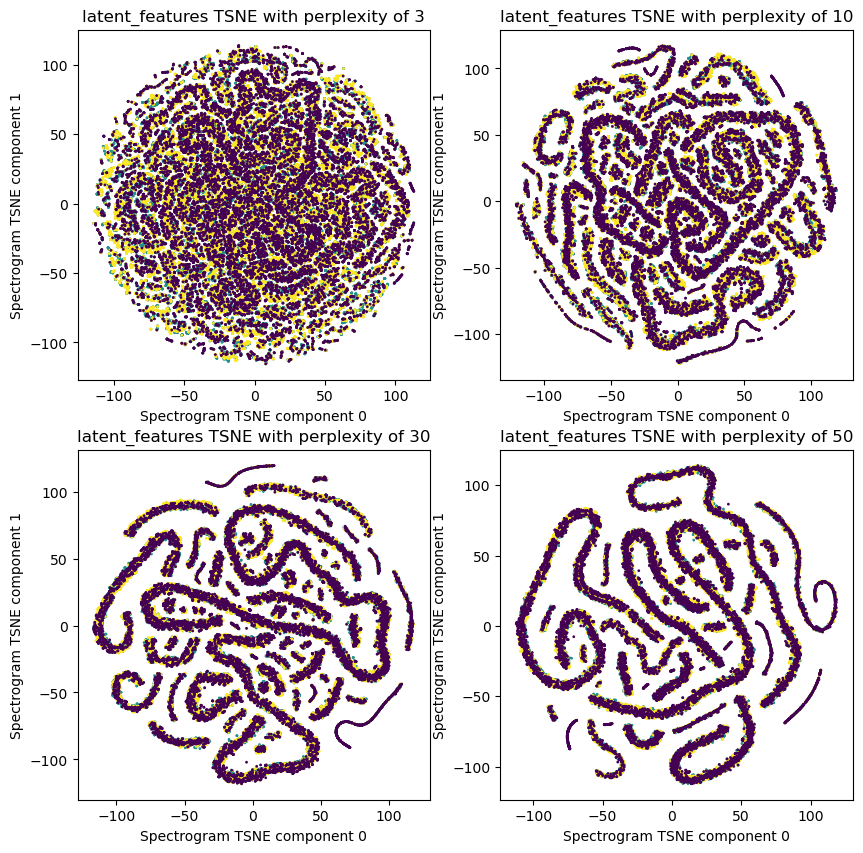

In [60]:
perplexities = [3, 10, 30, 50]
plen = len(perplexities)
sqrt = int(math.sqrt(plen))
fig, axes = plt.subplots(sqrt,sqrt, figsize=(10,10))
for i in range(plen):
    perplexity = perplexities[i]
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity).fit_transform(latent_features)
    ax = axes[i//sqrt, i%sqrt]
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1, c=y)
    ax.set_xlabel("Spectrogram TSNE component 0")
    ax.set_ylabel("Spectrogram TSNE component 1")
    ax.set_title(f"latent_features TSNE with perplexity of {perplexity}")
plt.show()

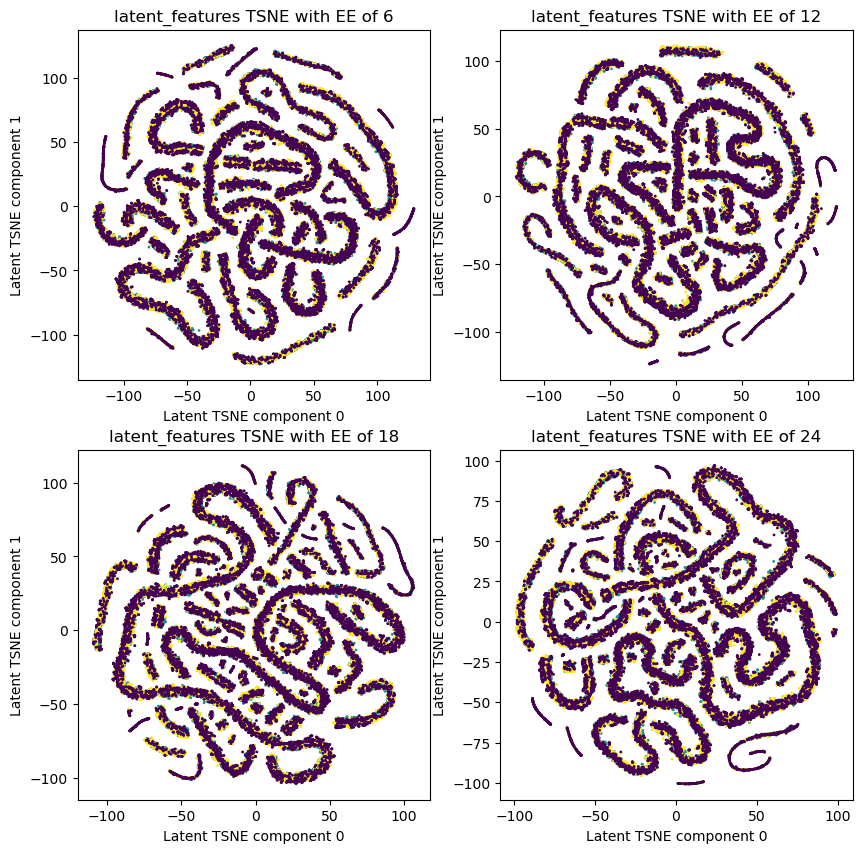

In [61]:
early_exagerations = [6, 12, 18, 24]
elen = len(early_exagerations)
sqrt = int(math.sqrt(plen))
fig, axes = plt.subplots(sqrt,sqrt, figsize=(10,10))
for i in range(elen):
    ee = early_exagerations[i]
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30, early_exaggeration=ee).fit_transform(latent_features)
    ax = axes[i//sqrt, i%sqrt]
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1, c=y)
    ax.set_xlabel("Latent TSNE component 0")
    ax.set_ylabel("Latent TSNE component 1")
    ax.set_title(f"latent_features TSNE with EE of {ee}")
plt.show()

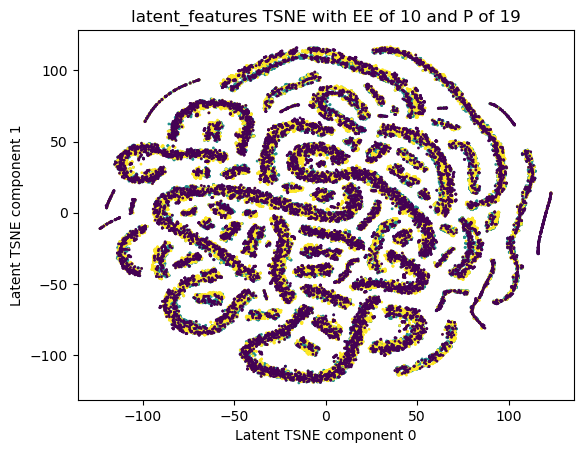

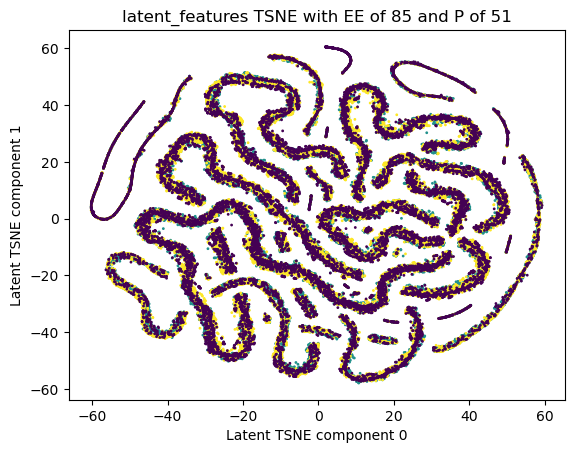

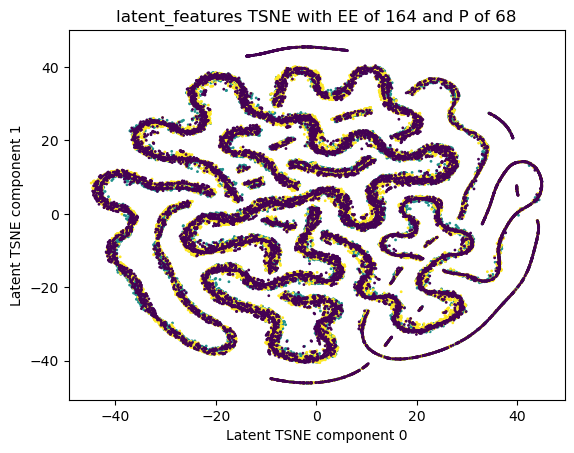

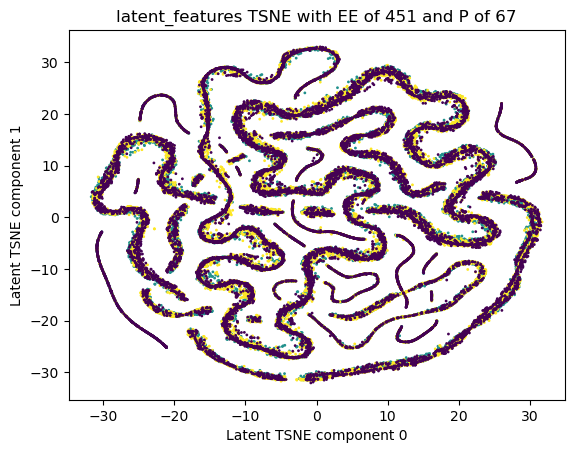

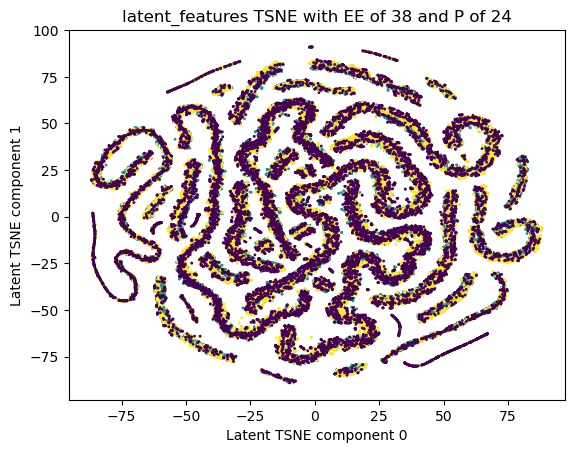

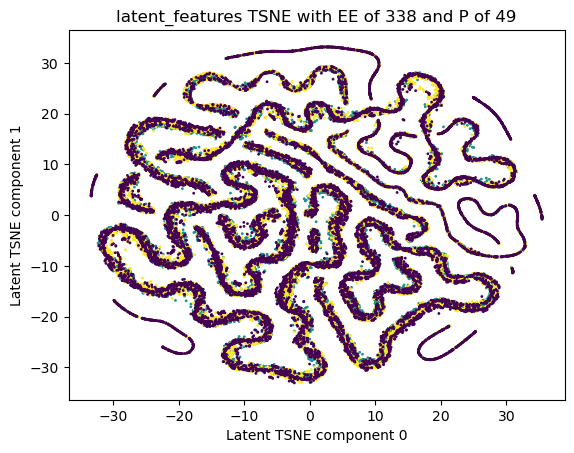

In [81]:
import random
for i in range(6):
    ee = random.randint(6, 500)
    p = random.randint(6, 70)
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=p, early_exaggeration=ee).fit_transform(latent_features)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1, c=y)
    plt.xlabel("Latent TSNE component 0")
    plt.ylabel("Latent TSNE component 1")
    plt.title(f"latent_features TSNE with EE of {ee} and P of {p}")
    plt.show()

# Clustering

In [80]:
# Try out some clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
from collections import Counter
clusters = [3, 5, 7, 10]
print(pred.shape)
for k in clusters:
    pred = KMeans(n_clusters=k, random_state=67, n_init="auto").fit_predict(latent_features)


    for cluster_id in range(k):
        idx = np.where(pred == cluster_id)[0]
        true_labels_in_cluster = y[idx]
        
        counts = Counter(true_labels_in_cluster)
        total = len(true_labels_in_cluster)
        ratios = {label: count / total for label, count in counts.items()}
        print(f"Cluster {cluster_id}:")
        for label, ratio in ratios.items():
            print(f"  Label {label}: {ratio:.2f}")
    print()
        


(69705,)
Cluster 0:
  Label 1: 0.41
  Label 2: 0.35
  Label 0: 0.24
Cluster 1:
  Label 1: 0.26
  Label 2: 0.12
  Label 0: 0.62
Cluster 2:
  Label 1: 0.52
  Label 2: 0.30
  Label 0: 0.18

Cluster 0:
  Label 1: 0.40
  Label 2: 0.35
  Label 0: 0.25
Cluster 1:
  Label 1: 0.42
  Label 2: 0.20
  Label 0: 0.38
Cluster 2:
  Label 1: 0.52
  Label 2: 0.33
  Label 0: 0.15
Cluster 3:
  Label 1: 0.34
  Label 2: 0.37
  Label 0: 0.29
Cluster 4:
  Label 1: 0.22
  Label 2: 0.02
  Label 0: 0.76

Cluster 0:
  Label 1: 0.39
  Label 2: 0.35
  Label 0: 0.25
Cluster 1:
  Label 1: 0.47
  Label 2: 0.27
  Label 0: 0.26
Cluster 2:
  Label 1: 0.52
  Label 2: 0.33
  Label 0: 0.15
Cluster 3:
  Label 1: 0.41
  Label 2: 0.32
  Label 0: 0.28
Cluster 4:
  Label 1: 0.18
  Label 0: 0.82
Cluster 5:
  Label 1: 0.28
  Label 2: 0.18
  Label 0: 0.55
Cluster 6:
  Label 1: 0.31
  Label 2: 0.38
  Label 0: 0.31

Cluster 0:
  Label 1: 0.39
  Label 2: 0.36
  Label 0: 0.26
Cluster 1:
  Label 1: 0.45
  Label 2: 0.22
  Label 0: 0.33
C